In [1]:
from multifitoolbox import * 
import matplotlib.pyplot as plt

# Plot parameters 
plt.rcParams.update({
    "font.family": "georgia",
    'text.latex.preamble': r'\\usepackage{amsmath}',
    'mathtext.fontset': 'cm',
})

K = 2 
sample_sizes = [8, 25, 50]

funcs = [
    lambda x: np.exp(-x) * np.sin(2*math.pi*x), 
    lambda x: np.sin(2*math.pi*x),
    lambda x: np.exp(-x)
]

# # LINEAR-A 
# funcs = [
#     lambda x: ((6*x-2)**2 * np.sin(12*x-4)),
#     lambda x: ((6*x-2)**2 * np.sin(12*x-4) + 10*(x-0.5) + 5),
#     lambda x: -(6*x-2)**2 * np.sin(12*x-4) - (x-0.5)**2
# ]

# # LINEAR-B 
# funcs = [
#     lambda x: ((5*x**2) * np.sin(12*x)), 
#     lambda x: (2*(5*x**2) * np.sin(12*x)+(x**3-0.5*np.sin(3*x-0.5))+4*np.cos(2*x)),
#     lambda x: ((5*x**2) * np.sin(12*x) + 12*np.tanh(x-0.5))
# ]

# # NONLINEAR-A 
# funcs = [
#     lambda x: (x - np.sqrt(2))*np.sin(8*math.pi*x)**2, 
#     lambda x: np.sin(8*math.pi*x), 
#     lambda x: np.exp(-math.pi*x)*np.sin(8*math.pi*x)
# ]

# # NONLINEAR-B 
# funcs = [
#     lambda x: x * np.exp(np.cos(15*(2*x - 0.2))) - 1, 
#     lambda x: np.cos(15*x), 
#     lambda x: np.tanh(np.cos(15*x)**2)
# ]

xmin = 0
xmax = 5

Xtest = np.linspace(xmin,xmax,1000).reshape(1,-1)
Ytest = funcs[0](Xtest.ravel())

d = {}

# Generating nested data 
for k in range(K+1):
    np.random.seed(42)
    # Generating the input data 
    d[k] = {
        'X':np.random.uniform(xmin, xmax, size=sum(sample_sizes[:k+1])).reshape(1, -1), 
    }
    # Generating the output training data
    d[k]['Y'] = funcs[k](d[k]['X']).ravel()

    # Appropriately scaling the high-fidelity function
    if k == 0:
        Ytest = (Ytest - np.mean(d[0]['Y'])) / np.max(np.abs(d[k]['Y']))
    
    # Giving mean zero and variance 1 
    d[k]['Y'] = (d[k]['Y'] - np.mean(d[k]['Y'])) / np.max(np.abs(d[k]['Y']))

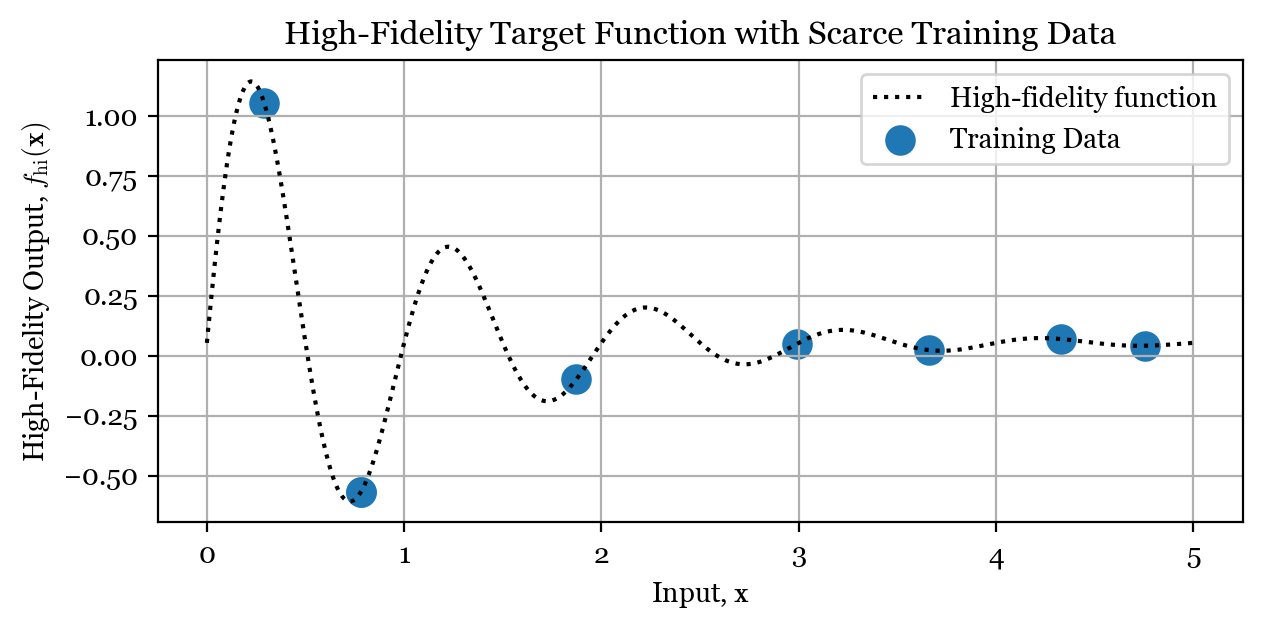

In [2]:
plt.figure(figsize=(7, 3), dpi=200)
plt.plot(Xtest.ravel(), Ytest, color='black', linestyle = 'dotted', label='High-fidelity function')
plt.scatter(d[0]['X'].ravel(), d[0]['Y'], s = 100.0, label='Training Data')
plt.xlabel("Input, $\mathbf{x}$")
plt.ylabel("High-Fidelity Output, $f_{\\text{hi}}(\mathbf{x})$")
plt.title("High-Fidelity Target Function with Scarce Training Data")
plt.legend()
plt.grid()

Initial Loss: -432.05365


 61%|██████    | 611/1000 [00:11<00:07, 51.70it/s, Current Loss: -493.86127 Learning Rate: 5.00e-01]


No Improvements Made! Breaking Loop...
Final Loss: -527.46118



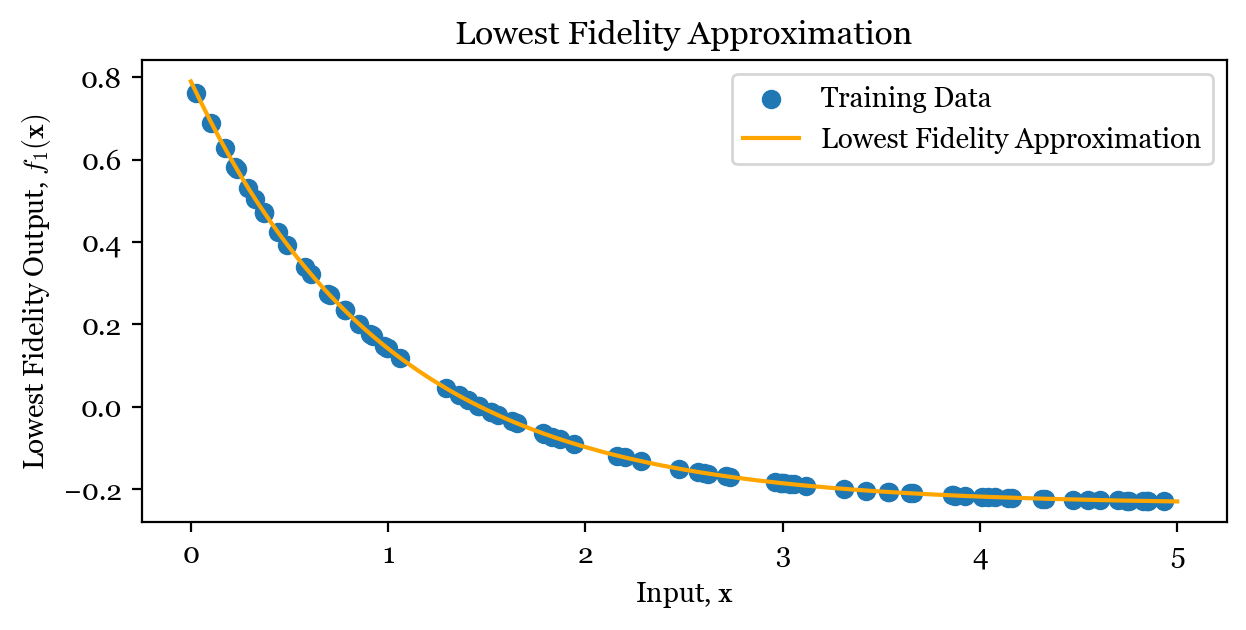

In [9]:
g1 = GaussianProcess()
g1.fit(d[2]['X'], d[2]['Y'], np.array([1.0]), noise_var = 1e-6)
g1.optimize_kernel_params(np.array([1.0]), lr = 1e0, tol = 1e-6, max_iter = 1000)
g1_test, g1_std = g1.predict(Xtest, include_std = True)
g1_std *= np.abs(g1_std)

plt.figure(figsize=(7, 3), dpi=200)
plt.scatter(d[2]['X'].ravel(), d[2]['Y'], label='Training Data')
plt.plot(Xtest.ravel(), g1_test.ravel(), color='orange', label = "Lowest Fidelity Approximation")
plt.fill_between(Xtest.ravel(), g1_test.ravel()-g1_std.ravel(), g1_test.ravel()+g1_std.ravel(), color='orange', alpha=0.3)
plt.xlabel("Input, $\mathbf{x}$")
plt.ylabel("Lowest Fidelity Output, $f_{1}(\mathbf{x})$")
plt.title("Lowest Fidelity Approximation")
plt.legend()


Initial Loss: 19044.24805


 25%|██▌       | 252/1000 [00:04<00:13, 56.01it/s, Current Loss: -10.91353 Learning Rate: 1.95e-03]


No Improvements Made! Breaking Loop...
Final Loss: -338.35632



(-1.0, 1.8)

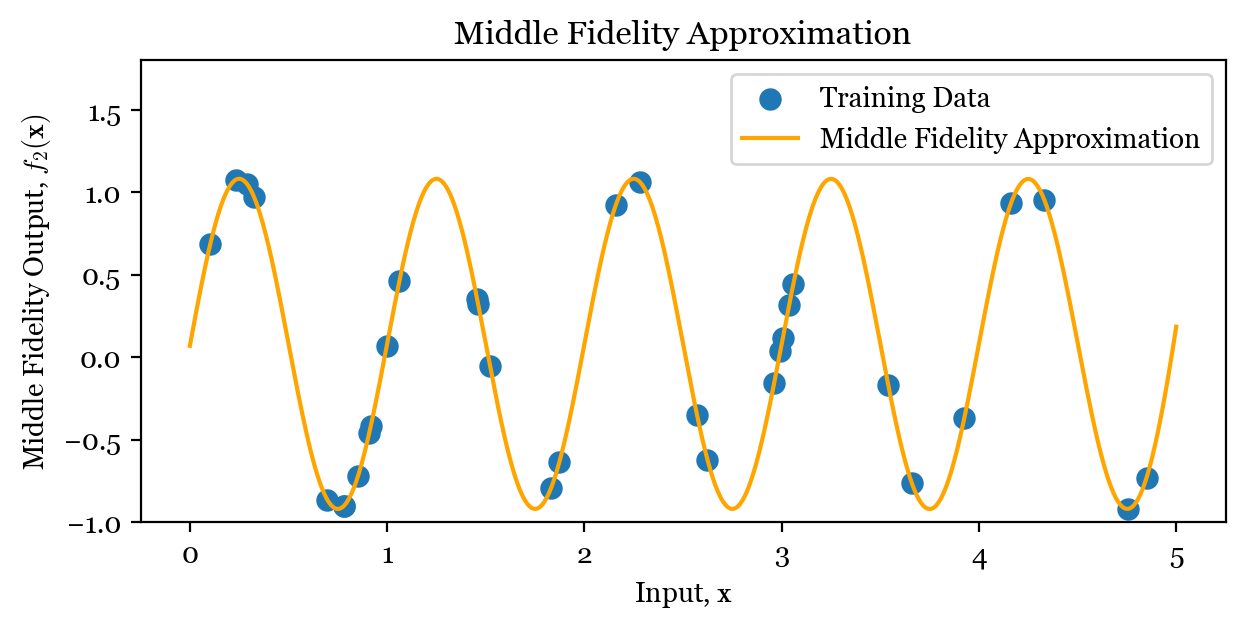

In [10]:
g2 = GaussianProcess()
g2.fit(
    np.vstack((d[1]['X'], d[2]['Y'][:sum(sample_sizes[0:2])].reshape(1,-1))), 
    d[1]['Y'], np.array([1.0, 1.0]), noise_var = 1e-6)
g2.optimize_kernel_params(np.array([1.0, 1.0]), lr = 1e0, tol = 1e-6, max_iter = 1000)
g2_test, g2_std = g2.predict(
    np.vstack((Xtest,g1_test.reshape(1,-1))), 
    include_std = True)
g2_std *= np.abs(g2_std)

plt.figure(figsize=(7, 3), dpi=200)
inds = np.argsort(d[1]['X'].ravel())
plt.scatter(d[1]['X'].ravel(), d[1]['Y'],s = 50.0, label='Training Data')
plt.plot(Xtest.ravel(), g2_test.ravel(), color='orange', label = "Middle Fidelity Approximation")
plt.fill_between(Xtest.ravel(), g2_test.ravel()-g2_std.ravel(), g2_test.ravel()+g2_std.ravel(), color='orange', alpha=0.3)
plt.xlabel("Input, $\mathbf{x}$")
plt.ylabel("Middle Fidelity Output, $f_{2}(\mathbf{x})$")
plt.title("Middle Fidelity Approximation")
plt.legend()
plt.ylim([-1.0, 1.8])

In [15]:
g3 = GaussianProcess(double_precision = True)
g3.fit(
    np.vstack((d[0]['X'], d[1]['Y'][:sum(sample_sizes[0:1])], d[2]['Y'][:sum(sample_sizes[0:1])].reshape(1,-1))), 
    d[0]['Y'], np.array([1.0, 1.0, 1.0]), noise_var = 1e-6)
g3.optimize_kernel_params(np.array([1.0, 1.0, 1.0]), lr = 10, tol = 1e-8, max_iter = 5000)
g3_test, g3_std = g3.predict(
    np.vstack((Xtest,g2_test.reshape(1,-1), g1_test.reshape(1,-1))), 
    include_std = True)
g3_std *= 2.15 * np.abs(g3_std)

Initial Loss: 16.26622


100%|██████████| 5000/5000 [02:11<00:00, 37.94it/s, Current Loss: -13.93260 Learning Rate: 3.12e-01]


Final Loss: -13.93260



In [ ]:
g4 = GaussianProcess(double_precision = True)
g4.fit(
    np.vstack((d[0]['X'], d[1]['Y'][:sum(sample_sizes[0:1])])), 
    d[0]['Y'], np.array([1.0, 1.0]), noise_var = 1e-6)
g4.optimize_kernel_params(np.array([1.0, 1.0]), lr = 10, tol = 1e-8, max_iter = 5000)
g4_test, g4_std = g4.predict(
    np.vstack((Xtest,g2_test.reshape(1,-1))), 
    include_std = True)
g4_std *= 2.15 * np.abs(g4_std)

Initial Loss: 16.09954


100%|██████████| 5000/5000 [01:29<00:00, 55.99it/s, Current Loss: -14.05905 Learning Rate: 3.12e-01]


Final Loss: -14.05905



In [ ]:
g5 = GaussianProcess(double_precision = True)
g5.fit(
    np.vstack((d[0]['X'])), 
    d[0]['Y'], np.array([1.0e-1]), noise_var = 1e-6)
g5.optimize_kernel_params(np.array([1.0]), lr = 1e1, tol = 1e-8, max_iter = 5000)
g5_test, g5_std = g5.predict(
    np.vstack((Xtest)), 
    include_std = True)
g5_std *= 2.15 * np.abs(g5_std)

Initial Loss: 14.81894


  9%|▉         | 473/5000 [00:08<01:18, 57.55it/s, Current Loss: -3.32999 Learning Rate: 6.10e-04]

NameError: name 'g5_test' is not defined

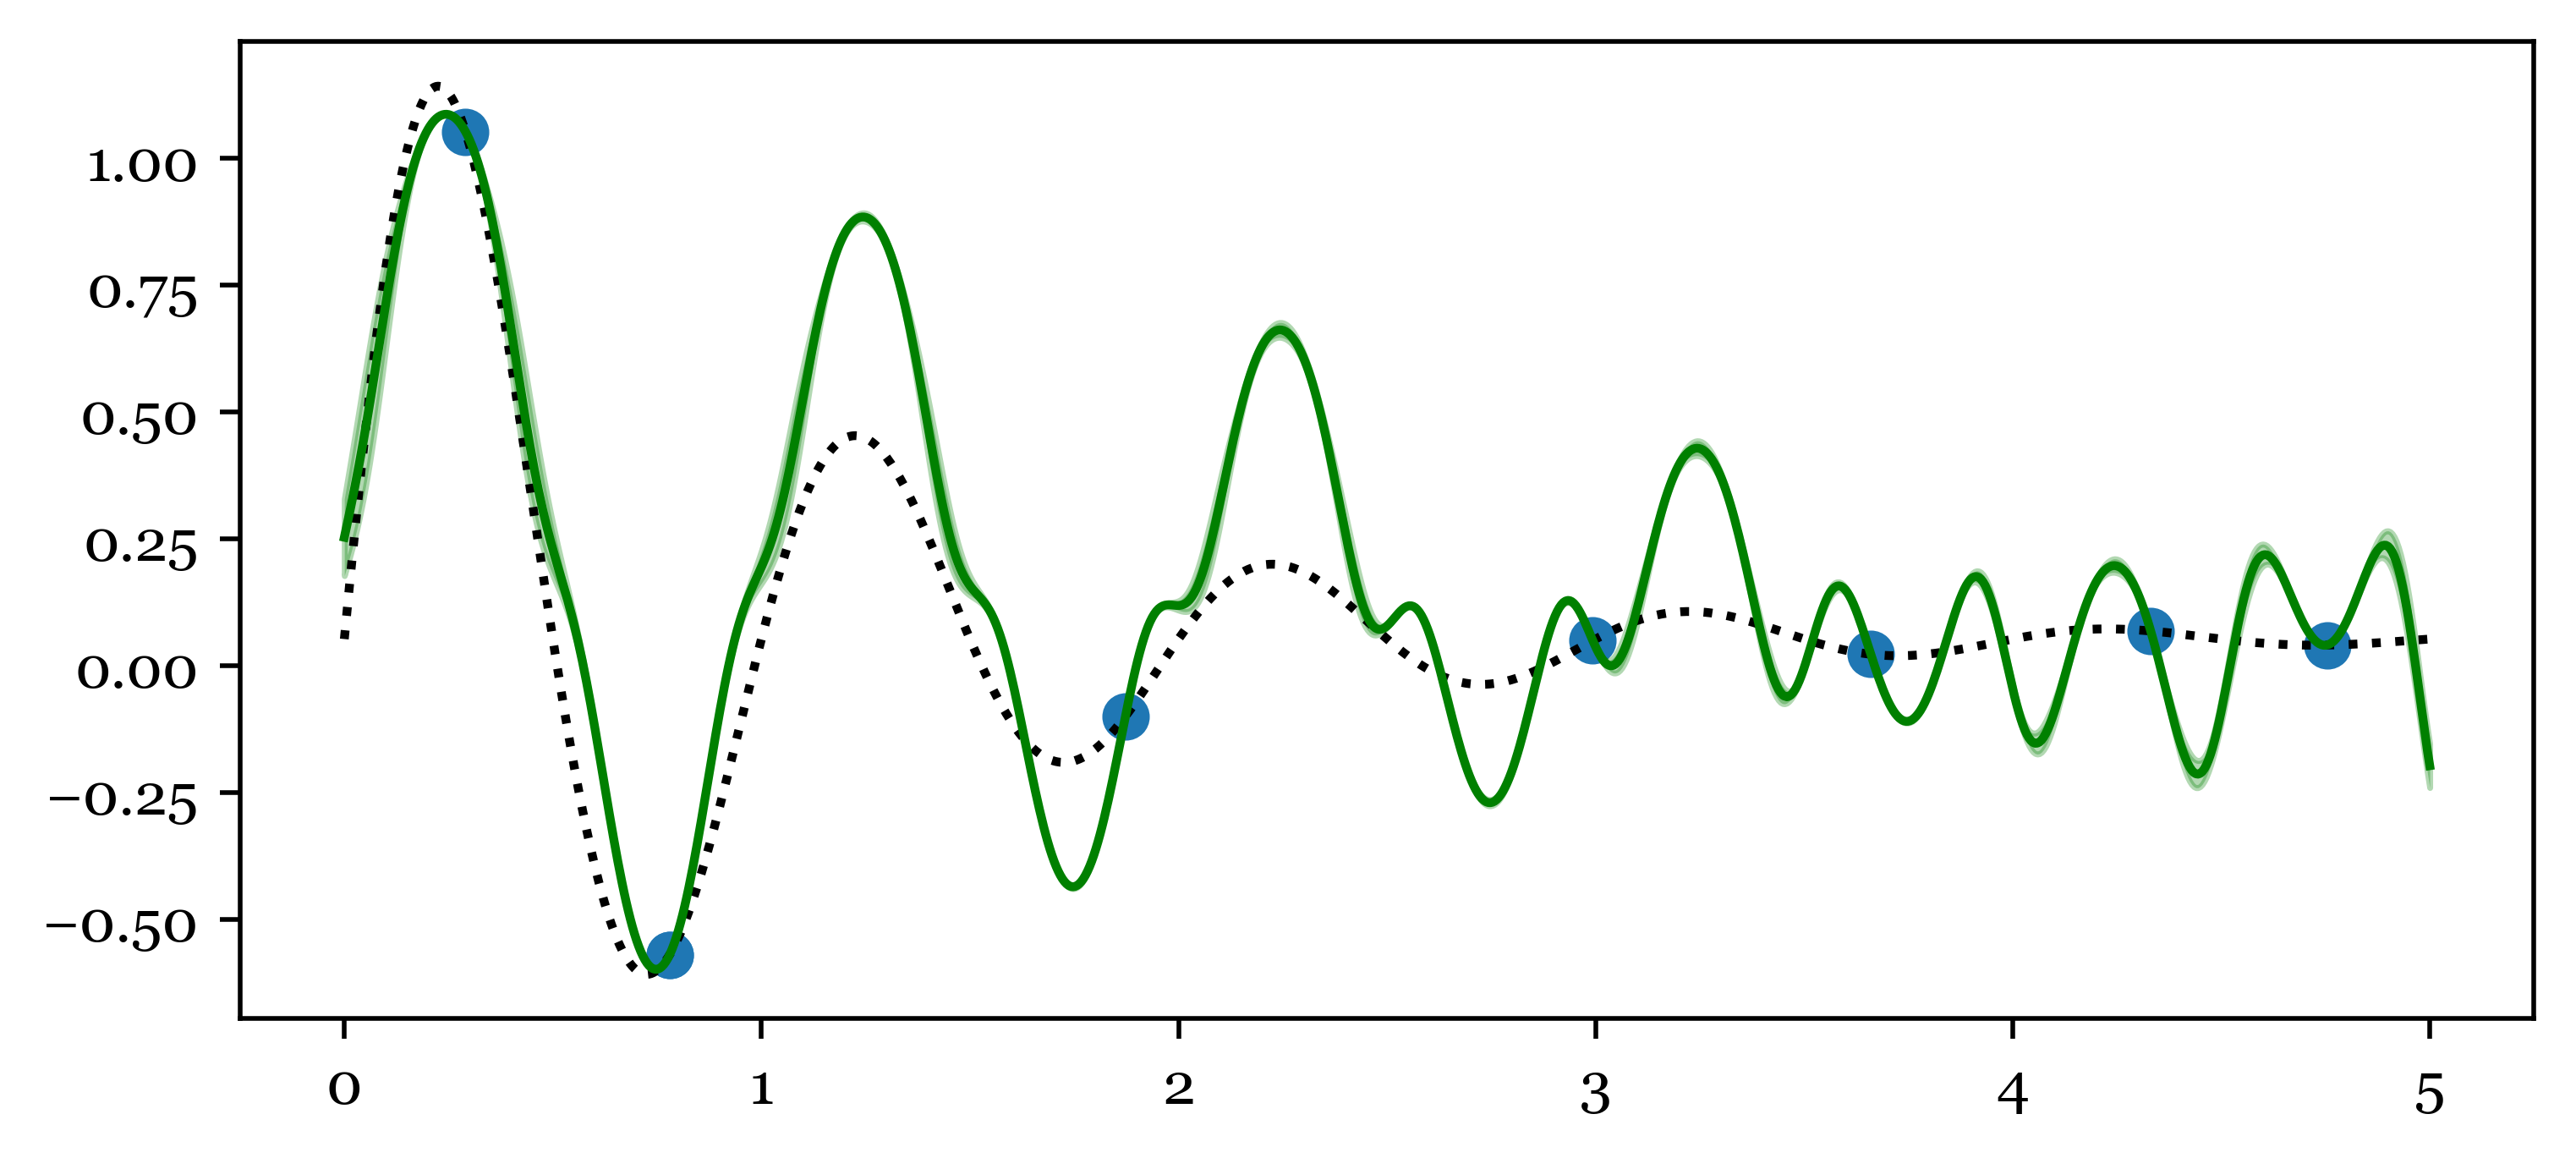

In [17]:
plt.figure(figsize=(7, 3), dpi=500)
plt.plot(Xtest.ravel(), Ytest, color='black', linestyle = 'dotted', label='Target Function')
plt.scatter(d[0]['X'].ravel(), d[0]['Y'],s = 50.0, label='Training Data')
plt.plot(Xtest.ravel(), g3_test.ravel(), color='green', label = "Hyperkriging Approximation")
plt.fill_between(Xtest.ravel(), g3_test.ravel()-g3_std.ravel(), g3_test.ravel()+g3_std.ravel(), color='green', alpha=0.3)

# plt.plot(Xtest.ravel(), g4_test.ravel(), color='blue', label = "Kriging Approximation")
# plt.fill_between(Xtest.ravel(), g4_test.ravel()-g4_std.ravel(), g4_test.ravel()+g4_std.ravel(), color='lightblue', alpha=0.3)

plt.plot(Xtest.ravel(), g5_test.ravel(), color='blue', label = "Kriging Approximation")
plt.fill_between(Xtest.ravel(), g5_test.ravel()-g5_std.ravel(), g5_test.ravel()+g5_std.ravel(), color='lightblue', alpha=0.3)

plt.xlabel("Input, $\mathbf{x}$")
plt.ylabel("High-Fidelity Output, $f_{\\text{hi}}(\mathbf{x})$")
plt.title("Hyperkriging vs. High-Fidelity Kriging Comparison")
plt.legend()
plt.ylim([-1.0, 1.8])

In [ ]:
# Kriging Model
kriging_model = Kriging(K, sample_sizes, d) 
kriging_model.fit(sigma_guess = 1e-3*np.ones(1), lr = 1e-1, max_iter = 1000)

Yhat_kriging, Ystd_kriging = kriging_model.predict(Xtest)
Ystd_kriging = 2.15*Ystd_kriging

Initial Loss: -4.49613


 55%|█████▌    | 551/1000 [00:08<00:07, 61.78it/s, Current Loss: -6.64345 Learning Rate: 1.00e-01]


No Improvements Made! Breaking Loop...
Final Loss: -6.64345



In [ ]:
# Kennedy/O'Hagan AR1 Model 
ar1_model = AR1(K, sample_sizes, d)
ar1_model.fit(param_scale = 1e-2, lr = 1e-1, max_iter = 1500)

Yhat_ar1, Ystd_ar1 = ar1_model.predict(Xtest)
Ystd_ar1 = 2.15*Ystd_ar1

Initial Loss: -26.92071


 17%|█▋        | 260/1500 [00:04<00:23, 52.01it/s, Current Loss: -335.94707 Learning Rate: 2.78e-18]


No Improvements Made! Breaking Loop...
Final Loss: -337.19432

Initial Loss: -1.70233


 18%|█▊        | 263/1500 [00:04<00:22, 54.05it/s, Current Loss: -115.93099 Learning Rate: 1.11e-17]


No Improvements Made! Breaking Loop...
Final Loss: -116.78037

Initial Loss: -4.57426


 41%|████      | 614/1500 [00:09<00:13, 64.88it/s, Current Loss: -7.32113 Learning Rate: 1.00e-01]


No Improvements Made! Breaking Loop...
Final Loss: -7.32113



In [ ]:
# NARGP Model 
nargp_model = NARGP(K, sample_sizes, d)
nargp_model.fit(param_scale  = 1e-3, lr = 5e-1, max_iter = 5000)

Yhat_nargp, Ystd_nargp = nargp_model.predict(Xtest)
Ystd_nargp = 2.15*Ystd_nargp

Initial Loss: -9.31504


  6%|▌         | 278/5000 [00:04<01:22, 57.39it/s, Current Loss: -335.50015 Learning Rate: 3.47e-18]


No Improvements Made! Breaking Loop...
Final Loss: -337.17390

Initial Loss: -2.23759


  5%|▌         | 268/5000 [00:04<01:20, 58.92it/s, Current Loss: -135.88954 Learning Rate: 2.78e-17]


No Improvements Made! Breaking Loop...
Final Loss: -136.24552

Initial Loss: -4.06079


100%|██████████| 5000/5000 [01:23<00:00, 59.74it/s, Current Loss: -12.71542 Learning Rate: 5.00e-01]


Final Loss: -12.71542



In [ ]:
# Hyperkriging Model 
pfsgp_model = Hyperkriging(K, sample_sizes, d)
pfsgp_model.fit(param_scale= 1e-3, lr = 1.0, max_iter = 5000)

Yhat_pfsgp, Ystd_pfsgp = pfsgp_model.predict(Xtest)
Ystd_pfsgp = 2.15*Ystd_pfsgp

Initial Loss: -33.98745


  5%|▌         | 270/5000 [00:04<01:23, 56.37it/s, Current Loss: -344.94819 Learning Rate: 3.47e-18]


No Improvements Made! Breaking Loop...
Final Loss: -346.98482

Initial Loss: -2.23759


  5%|▌         | 268/5000 [00:04<01:19, 59.34it/s, Current Loss: -135.88954 Learning Rate: 2.78e-17]


No Improvements Made! Breaking Loop...
Final Loss: -136.24552

Initial Loss: -4.01638


100%|██████████| 5000/5000 [01:24<00:00, 58.93it/s, Current Loss: -14.67636 Learning Rate: 1.00e+00]

Final Loss: -14.67636

[89.39629473  6.69506689  0.97094442]


In [ ]:
from sklearn.metrics import mean_squared_error as MSE

print("Kriging: %.5f" % (np.sqrt(MSE(Ytest, Yhat_kriging))))
print("AR1: %.5f" % (np.sqrt(MSE(Ytest, Yhat_ar1))))
print("NARGP: %.5f" % (np.sqrt(MSE(Ytest, Yhat_nargp))))
print("Hyperkriging: %.5f" % (np.sqrt(MSE(Ytest, Yhat_pfsgp))))

Kriging: 0.12389
AR1: 0.22965
NARGP: 0.21624
Hyperkriging: 0.05372


(0.0, 5.0)

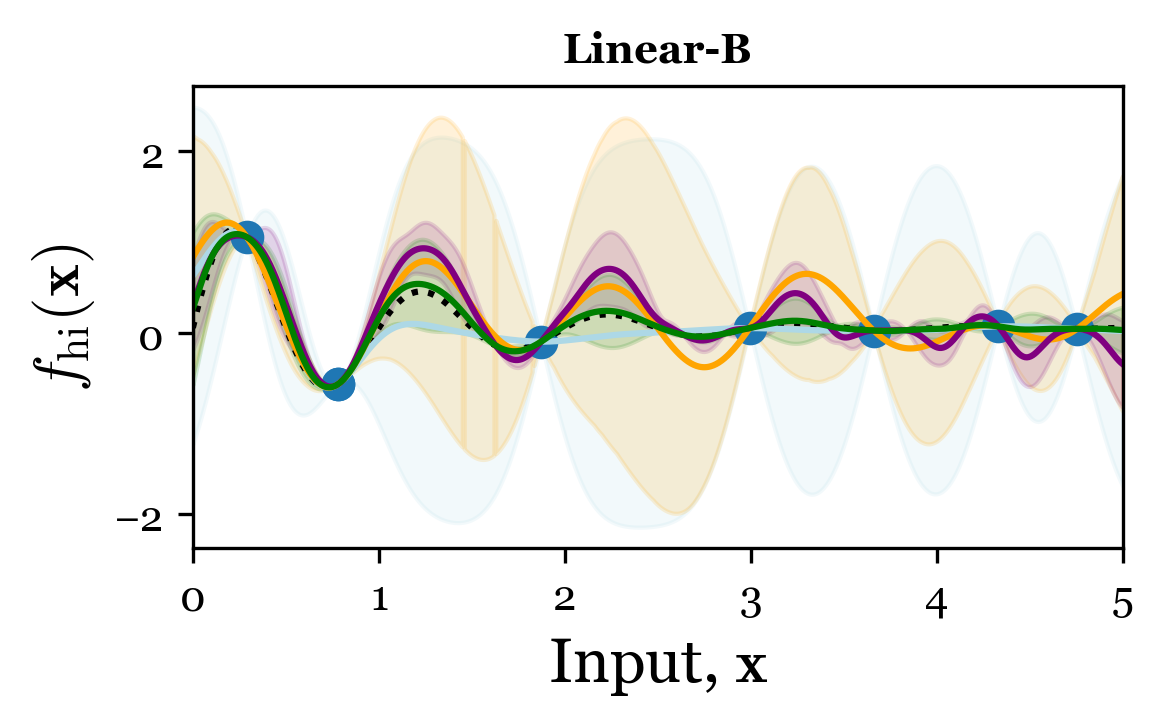

In [ ]:
plt.figure(figsize=(4,2), dpi = 300)
plt.plot(Xtest.ravel(), Ytest, linestyle = 'dotted', color = 'black', label = "Target Function")
# Kriging 
plt.plot(Xtest.ravel(), Yhat_kriging.ravel(), label = "Kriging", color = 'lightblue')
plt.fill_between(Xtest.ravel(), Yhat_kriging.ravel() - Ystd_kriging.ravel(), Yhat_kriging.ravel() + Ystd_kriging.ravel(), color = 'lightblue', alpha = 0.15)
# AR1
plt.plot(Xtest.ravel(), Yhat_ar1.ravel(), label = "AR1", color = 'orange')
plt.fill_between(Xtest.ravel(), Yhat_ar1.ravel() - Ystd_ar1.ravel(), Yhat_ar1.ravel() + Ystd_ar1.ravel(), color = 'orange', alpha = 0.15)
# NARGP 
plt.plot(Xtest.ravel(), Yhat_nargp.ravel(), label = "NARGP", color = 'purple')
plt.fill_between(Xtest.ravel(), Yhat_nargp.ravel() - Ystd_nargp.ravel(), Yhat_nargp.ravel() + Ystd_nargp.ravel(), color = 'purple', alpha = 0.15)
# Hyperkriging 
plt.plot(Xtest.ravel(), Yhat_pfsgp.ravel(), label = "Hyperkriging", color = 'green')
plt.fill_between(Xtest.ravel(), Yhat_pfsgp.ravel() - Ystd_pfsgp.ravel(), Yhat_pfsgp.ravel() + Ystd_pfsgp.ravel(), color = 'green', alpha = 0.15)

# High-Fidelity Datapoints
plt.scatter(d[0]['X'].ravel(), d[0]['Y'].ravel(), s = 50.0, label = "High-Fidelity Datapoints")
plt.title("Comparison of Multi-Fidelity Regression Techniques", fontsize=20, fontweight='bold')
plt.title("Linear-B", fontsize=10, fontweight='bold')
plt.xlabel("Input, $\mathbf{x}$", fontsize=15)
plt.ylabel("$f_{\\text{hi}}(\mathbf{x})$", fontsize=15)
#plt.legend(fontsize=5)
#plt.ylim([-1.4, 1])
plt.xlim([xmin, xmax])